# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gzip
import shutil
import os
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

import acquire_nick as an
import prepare_nick as pn
import wrangle as w

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plotting defaults
plt.rc('figure', figsize=(15, 8))
plt.rc('font', size=16)

In [2]:
df = w.wrangle_df()
df.head()

Using cached CSV


,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [3]:
df.shape

(6923, 43)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 5 to 443319
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 6923 non-null   object 
 1   success               6923 non-null   int64  
 2   success_rating        6923 non-null   float64
 3   genres                6921 non-null   object 
 4   cast_actor_1          6923 non-null   object 
 5   cast_actor_2          6923 non-null   object 
 6   cast_actor_3          6923 non-null   object 
 7   total_n_cast          6923 non-null   float64
 8   budget                6923 non-null   float64
 9   revenue               6923 non-null   float64
 10  profit_amount         6923 non-null   float64
 11  vote_average          6923 non-null   float64
 12  vote_count            6923 non-null   float64
 13  production_companies  6923 non-null   object 
 14  production_countries  6893 non-null   object 
 15  overview           

In [5]:
df.budget.astype(int)
df.describe()

,success,success_rating,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,popularity,runtime,profitable,release_year,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,is_long_movie,ROI
count,6923.000000,6923.000000,6923.000000,6.923000e+03,6.923000e+03,6.923000e+03,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6923.000000,6.923000e+03
mean,0.399827,9.944552,22.268092,2.645070e+07,7.327500e+07,4.682430e+07,6.255742,596.601040,8.959213,108.369782,0.417738,1999.442005,0.156435,0.103279,0.498917,0.104579,0.194713,0.261014,0.152246,0.352448,0.052434,0.242380,0.078723,0.087245,0.017911,6.876932,15.313303,0.215080,3.023378e+00
std,0.489898,22.006074,19.078528,3.637056e+07,1.504085e+08,1.257992e+08,0.940820,1134.659609,12.430699,20.753765,0.493222,15.695885,0.363294,0.304345,0.500035,0.306032,0.396008,0.439219,0.359285,0.477767,0.222917,0.428554,0.269326,0.282215,0.132639,3.376011,8.557498,0.410908,6.328836e+00
min,0.000000,0.000000,3.000000,1.020000e+06,1.000000e+00,-1.657101e+08,0.000000,0.000000,0.000308,0.000000,0.000000,1915.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.250000e-07
25%,0.000000,1.073540,12.000000,8.000000e+06,3.391863e+06,-6.574476e+06,5.700000,53.000000,4.706160,95.000000,0.000000,1992.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000,0.000000,3.666186e-01
50%,0.000000,4.505697,17.000000,1.000000e+07,1.945000e+07,5.350369e+06,6.300000,191.000000,7.772822,105.000000,0.000000,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,15.000000,0.000000,1.456237e+00
75%,1.000000,10.914864,25.000000,3.000000e+07,7.379643e+07,4.480520e+07,6.900000,593.000000,11.154416,118.000000,1.000000,2011.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,22.000000,0.000000,3.421541e+00
max,1.000000,667.333333,313.000000,3.800000e+08,2.787965e+09,2.550965e+09,10.000000,14075.000000,547.488298,338.000000,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,31.000000,1.000000,1.906667e+02


In [6]:
df['success_rating'] = (df['revenue']/(df['budget'] * 2)) * df['vote_average']

In [7]:
df.head(5)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [8]:
df[df.success == 1].cast_actor_1.value_counts()

Tom Hanks                   27
Tom Cruise                  27
Sylvester Stallone          21
Clint Eastwood              21
Adam Sandler                18
Denzel Washington           17
Sean Connery                16
Bruce Willis                16
Jim Carrey                  16
Mel Gibson                  16
Ben Stiller                 15
Robert De Niro              15
Johnny Depp                 15
Meryl Streep                14
Will Smith                  14
Robin Williams              14
Mark Wahlberg               14
Paul Newman                 14
Keanu Reeves                13
Nicolas Cage                13
Brad Pitt                   13
John Travolta               13
Leonardo DiCaprio           12
Steve Martin                12
Kevin Costner               12
George Clooney              12
Arnold Schwarzenegger       12
Al Pacino                   12
Harrison Ford               12
Matt Damon                  12
Shah Rukh Khan              12
Robert Redford              11
Eddie Mu

In [9]:
df.groupby('release_year').success.sum().tail(15)

release_year
2003     70
2004     77
2005     79
2006     87
2007     95
2008     97
2009     95
2010    100
2011    107
2012    101
2013    124
2014    109
2015    114
2016    101
2017     43
Name: success, dtype: int64

<AxesSubplot:xlabel='id'>

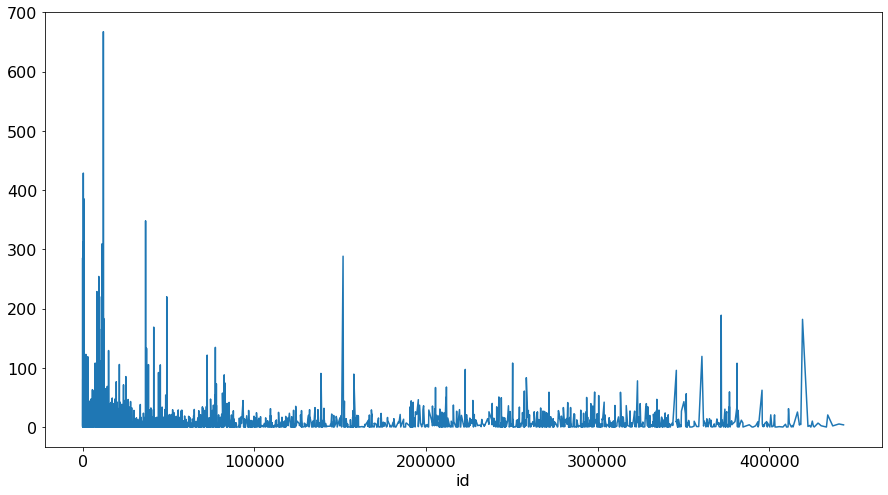

In [10]:
df.success_rating.plot()

In [11]:
df['success'] = (df['success_rating'] > 6.5) * 1

In [12]:
df.sample(5)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10330,Freaky Friday,1,12.718884,Comedy,Jamie Lee Curtis,Lindsay Lohan,Mark Harmon,34.0,26000000.0,110230332.0,84230332.0,6.0,919.0,WaltDisneyPictures GunnFilms CasualFridayProdu...,UnitedStatesofAmerica,Mother and daughter bicker over everything -- ...,7.867999,97.0,1,2003-08-03,2003,tt0322330,WaltDisneyPictures,0,0,0,0,0,0,0,1,0,0,0,0,0,8,3,Sunday,0,4.239628,very high,high
1947,An Unfinished Life,0,2.079042,Drama,Robert Redford,Jennifer Lopez,Morgan Freeman,15.0,30000000.0,18618284.0,-11381716.0,6.7,165.0,MiramaxFilms RevolutionStudios PersistentEnter...,UnitedStatesofAmerica Germany,"Stoic and heartbroken, Einar Gilkyson quietly ...",7.761954,108.0,0,2005-09-09,2005,tt0350261,MiramaxFilms,0,0,1,0,0,0,0,0,0,0,0,0,0,9,9,Friday,0,0.620609,avg,high
11015,The Relic,0,1.641236,Horror Mystery Thriller,Penelope Ann Miller,Tom Sizemore,Linda Hunt,27.0,60000000.0,33956608.0,-26043392.0,5.8,130.0,ParamountPictures UniversalPictures Toho-Towa ...,Germany Japan NewZealand UnitedKingdom UnitedS...,A researcher at Chicago's Natural History Muse...,7.699967,110.0,0,1997-01-10,1997,tt0120004,ParamountPictures,0,1,0,0,0,1,0,0,0,0,1,0,0,1,10,Friday,0,0.565943,avg,very high
26941,Afterglow,0,1.109682,Drama Romance Comedy,Nick Nolte,Julie Christie,Lara Flynn Boyle,5.0,8000000.0,2465960.0,-5534040.0,7.2,5.0,SonyPicturesClassics,UnitedStatesofAmerica,A handyman with marital problems meets a house...,1.426289,119.0,0,1997-12-26,1997,tt0118566,SonyPicturesClassics,0,0,1,0,1,0,0,1,0,0,0,0,0,12,26,Friday,0,0.308245,avg,low
9722,Bewitched,0,3.710857,Comedy Fantasy Romance,Nicole Kidman,Will Ferrell,Shirley MacLaine,19.0,85000000.0,131426169.0,46426169.0,4.8,463.0,ColumbiaPicturesCorporation RedWagonEntertainm...,UnitedStatesofAmerica,Thinking he can overshadow an unknown actress ...,9.276085,102.0,0,2005-06-21,2005,tt0374536,ColumbiaPicturesCorporation,0,0,0,0,1,0,0,1,0,0,0,1,0,6,21,Tuesday,0,1.546190,high,very high


In [13]:
def train_validate_test_split(df):
    ''' 
    This function takes in a dataframe and splits it 80:20.  The 20% will be our testing datafrme for our final model.  The 80% will be split a second time (70:30), creating our final training dataframe and a dataframe to validate our model with before testing.  Leaving us we a Train (56%), Validate(24%) and Test (20%) Dataframe from our original data (100%)
    '''
    
    train, test = train_test_split(df, 
                               train_size = 0.8,
                               random_state=1313)
    
    
    train, validate = train_test_split(train,
                                  train_size = 0.7,
                                  random_state=1313)
    
    
    return train, validate, test


train, validate, test = train_validate_test_split(df)

train.shape, validate.shape, test.shape

((3876, 43), (1662, 43), (1385, 43))

# Scaling and One Hot Encoding

In [14]:
# Scaling
# Columns to be scaled: 
scaler = MinMaxScaler()


In [15]:
# One Hot Encode for Genres

# df['is_genre_adventure'] = df.genres.apply(lambda genre_list: 'Adventure' in genre_list)
# df['is_genre_horror'] = df.genres.apply(lambda genre_list: 'Horror' in genre_list)
# df['is_genre_drama'] = df.genres.apply(lambda genre_list: 'Drama' in genre_list)
# df['is_genre_scifi'] = df.genres.apply(lambda genre_list: 'Science' in genre_list)
# df['is_genre_romance'] = df.genres.apply(lambda genre_list: 'Romance' in genre_list)
# df['is_genre_thriller'] = df.genres.apply(lambda genre_list: 'Thriller' in genre_list)
# df['is_genre_crime'] = df.genres.apply(lambda genre_list: 'Crime' in genre_list)
# df['is_genre_comedy'] = df.genres.apply(lambda genre_list: 'Comedy' in genre_list)
# df['is_genre_animation'] = df.genres.apply(lambda genre_list: 'Animation' in genre_list)
# df['is_genre_action'] = df.genres.apply(lambda genre_list: 'Action' in genre_list)
# df['is_genre_mystery'] = df.genres.apply(lambda genre_list: 'Mystery' in genre_list)
# df['is_genre_fantasy'] = df.genres.apply(lambda genre_list: 'Fantasy' in genre_list)
# df['is_genre_documentary'] = df.genres.apply(lambda genre_list: 'Documentary' in genre_list)

In [16]:
# One Hot Encode Production Company


In [17]:
df.production_company.value_counts()

UniversalPictures                                                  400
ParamountPictures                                                  386
TwentiethCenturyFoxFilmCorporation                                 291
ColumbiaPictures                                                   235
NewLineCinema                                                      187
WarnerBros.                                                        162
WaltDisneyPictures                                                 146
Metro-Goldwyn-Mayer(MGM)                                           109
ColumbiaPicturesCorporation                                        105
UnitedArtists                                                      101
MiramaxFilms                                                        97
TriStarPictures                                                     96
VillageRoadshowPictures                                             74
FoxSearchlightPictures                                              68
DreamW

In [18]:
# Variables for constructing models
x_train = train.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_train = train.success

x_validate = validate.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_validate = validate.success

x_test = test.drop(columns=['success', 'revenue', 'vote_average', 'success_rating'])
y_test = test.success

In [19]:
train.success.value_counts()

0    2324
1    1552
Name: success, dtype: int64

In [20]:
# Now that our training sample is ready, lets set up a baseline accuracy to improve upon
train['baseline'] = 0

baseline_accuracy = (train.baseline == train.success).mean()
print(f'Our baseline accuracy is {baseline_accuracy: .2%}')


Our baseline accuracy is  59.96%


In [21]:
# # Random Forest #

# # Make the Model
# forest = RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1313)

# # Fit the Model
# forest.fit(x_train, y_train)

# # Use the Model
# y_pred = forest.predict(x_train)


# performance = classification_report(y_train, y_pred, output_dict=True)

# # Classification Report
# pd.DataFrame(performance).transpose()

In [22]:
# Logistic Regression

# Make the Model
logit = LogisticRegression(C=10, random_state=1313)

# Select the Features we want focused on
features = ['runtime', 'budget']

# Fit the Model
logit.fit(x_train[features], y_train)

# Predictions
y_pred = logit.predict(x_train[features])

# Model Score
m_score = logit.score(x_train[features], y_train)

performance = classification_report(y_train, y_pred, output_dict=True, zero_division=0)

# Classification Report
pd.DataFrame(performance).transpose()


,precision,recall,f1-score,support
0,0.599587,1.000000,0.749677,2324.000000
1,0.000000,0.000000,0.000000,1552.000000
accuracy,0.599587,0.599587,0.599587,0.599587
macro avg,0.299794,0.500000,0.374839,3876.000000
weighted avg,0.359505,0.599587,0.449497,3876.000000


### Test different target variables

In [23]:
df_copy = df.copy()

In [24]:
df_copy.head(1)

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.49375,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075,avg,low


In [25]:
df_copy['success'] = (df_copy['success_rating'] > 6.5)
df_copy['success'].value_counts(normalize=True)

False    0.600173
True     0.399827
Name: success, dtype: float64

In [26]:
df_copy['success'] = (df_copy['success_rating'] > 7)
df_copy['success'].value_counts(normalize=True)

False    0.625163
True     0.374837
Name: success, dtype: float64

In [27]:
df_copy['success'] = (df_copy['success_rating'] > 7.5)
df_copy['success'].value_counts(normalize=True)

False    0.645529
True     0.354471
Name: success, dtype: float64

In [28]:
df_copy['success'] = (df_copy['success_rating'] > 8.5)
df_copy['success'].value_counts(normalize=True)

False    0.682363
True     0.317637
Name: success, dtype: float64

In [29]:
df_copy['success'] = (df_copy['success_rating'] > 9)
df_copy['success'].value_counts(normalize=True)

False    0.697819
True     0.302181
Name: success, dtype: float64

In [30]:
df_copy['success'] = (df_copy['success_rating'] > 10)
df_copy['success'].value_counts(normalize=True)

False    0.725697
True     0.274303
Name: success, dtype: float64

In [31]:
df_copy['success'] = (df_copy['success_rating'] > 12)
df_copy['success'].value_counts(normalize=True)

False    0.773653
True     0.226347
Name: success, dtype: float64

<AxesSubplot:xlabel='id'>

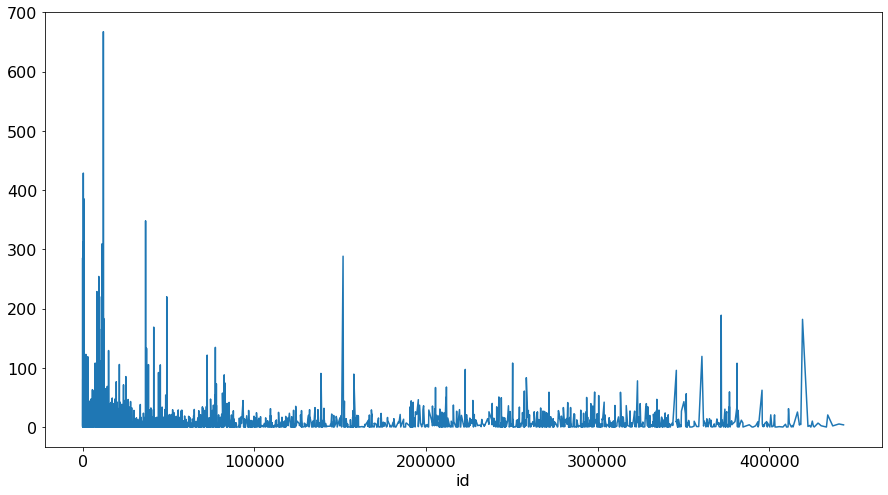

In [32]:
df_copy['success'] = (df_copy['success_rating'] > 6.5) * 1

df_copy.success_rating.plot()

In [33]:
# TAKEAWAYS/NOTES #
# Anything over 9 would need to have had either made more than double the budget, or get close to a perfect rating
# 

In [34]:
df[df.success == 1].total_n_cast.sort_values(ascending=False).head(15).mean()

178.53333333333333

In [35]:
df[df.success == 1].runtime.sort_values(ascending=False).head(10).mean()

234.9

In [36]:
df[df.success == 1].runtime.sort_values(ascending=False).head(50).mean()

195.34

In [37]:
df[df.success == 1].runtime.sort_values(ascending=False).head(100).mean()

181.18

# Dive Deeper
- Genre percentages
- Rule Sets for different movies/genres/production companies
- Insights gained from model

In [38]:
genre_list = ['is_genre_adventure', 'is_genre_horror',
       'is_genre_drama', 'is_genre_scifi', 'is_genre_romance',
       'is_genre_thriller', 'is_genre_crime', 'is_genre_comedy',
       'is_genre_animation', 'is_genre_action', 'is_genre_mystery',
       'is_genre_fantasy', 'is_genre_documentary']

In [39]:
# how much of the data is adventure
df.is_genre_adventure.value_counts(normalize=True)

0    0.843565
1    0.156435
Name: is_genre_adventure, dtype: float64

In [40]:
df[df.success == 1].is_genre_adventure.value_counts(normalize=True)

0    0.80672
1    0.19328
Name: is_genre_adventure, dtype: float64

In [41]:
for genre in df[genre_list]:
    print(df[genre].value_counts(normalize=True))
    print('----------------------------')
    

0    0.843565
1    0.156435
Name: is_genre_adventure, dtype: float64
----------------------------
0    0.896721
1    0.103279
Name: is_genre_horror, dtype: float64
----------------------------
0    0.501083
1    0.498917
Name: is_genre_drama, dtype: float64
----------------------------
0    0.895421
1    0.104579
Name: is_genre_scifi, dtype: float64
----------------------------
0    0.805287
1    0.194713
Name: is_genre_romance, dtype: float64
----------------------------
0    0.738986
1    0.261014
Name: is_genre_thriller, dtype: float64
----------------------------
0    0.847754
1    0.152246
Name: is_genre_crime, dtype: float64
----------------------------
0    0.647552
1    0.352448
Name: is_genre_comedy, dtype: float64
----------------------------
0    0.947566
1    0.052434
Name: is_genre_animation, dtype: float64
----------------------------
0    0.75762
1    0.24238
Name: is_genre_action, dtype: float64
----------------------------
0    0.921277
1    0.078723
Name: is_genre_mys

In [42]:
for genre in df[genre_list]:
    print(df[df.success == 1][genre].value_counts(normalize=True))

0    0.80672
1    0.19328
Name: is_genre_adventure, dtype: float64
0    0.895592
1    0.104408
Name: is_genre_horror, dtype: float64
0    0.544798
1    0.455202
Name: is_genre_drama, dtype: float64
0    0.892702
1    0.107298
Name: is_genre_scifi, dtype: float64
0    0.805636
1    0.194364
Name: is_genre_romance, dtype: float64
0    0.738801
1    0.261199
Name: is_genre_thriller, dtype: float64
0    0.843931
1    0.156069
Name: is_genre_crime, dtype: float64
0    0.638728
1    0.361272
Name: is_genre_comedy, dtype: float64
0    0.932442
1    0.067558
Name: is_genre_animation, dtype: float64
0    0.739523
1    0.260477
Name: is_genre_action, dtype: float64
0    0.921604
1    0.078396
Name: is_genre_mystery, dtype: float64
0    0.901012
1    0.098988
Name: is_genre_fantasy, dtype: float64
0    0.991691
1    0.008309
Name: is_genre_documentary, dtype: float64


<AxesSubplot:>

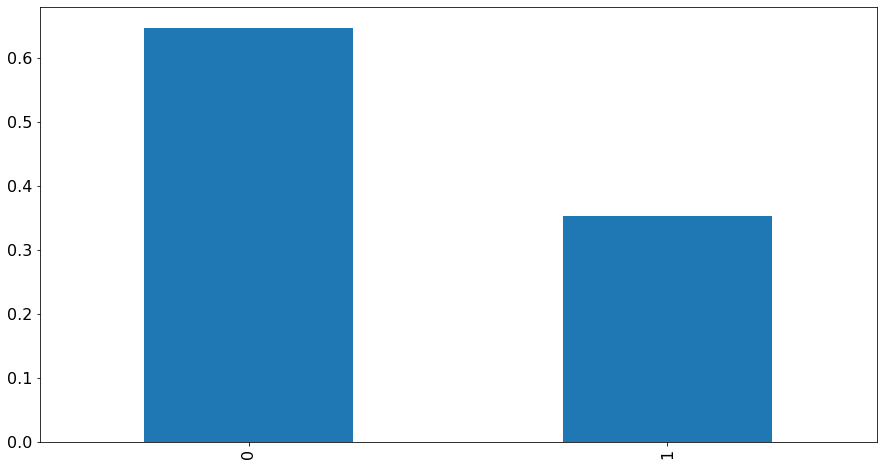

In [43]:
# how much of the data is comedy
df.is_genre_comedy.value_counts(normalize=True).plot.bar()

In [44]:
# how much of the data is drama
df.is_genre_drama.value_counts(normalize=True)

0    0.501083
1    0.498917
Name: is_genre_drama, dtype: float64

In [45]:
df.is_genre_horror.value_counts(normalize=True)

0    0.896721
1    0.103279
Name: is_genre_horror, dtype: float64

In [46]:
df.is_genre_thriller.value_counts(normalize=True)

0    0.738986
1    0.261014
Name: is_genre_thriller, dtype: float64

In [47]:
df.is_genre_action.value_counts(normalize=True)

0    0.75762
1    0.24238
Name: is_genre_action, dtype: float64

In [48]:
df[df.success == 1].budget.sort_values()

id
1939        1020000.0
94329       1100000.0
33061       1100000.0
11462       1103000.0
31526       1114000.0
56164       1180280.0
36685       1200000.0
176         1200000.0
500         1200000.0
24924       1200000.0
429         1200000.0
176124      1200000.0
24153       1200000.0
845         1200000.0
11319       1200000.0
24128       1200000.0
2671        1200000.0
20770       1200000.0
11219       1200000.0
16220       1200000.0
43884       1200000.0
17058       1202007.0
29244       1243000.0
43266       1250000.0
28580       1250000.0
19997       1250000.0
1643        1250000.0
23730       1250000.0
9725        1250000.0
14554       1271000.0
223         1288000.0
192558      1300000.0
488         1300000.0
103         1300000.0
43881       1300000.0
25188       1300000.0
13986       1300000.0
11951       1300000.0
31626       1333333.0
27367       1344000.0
100         1350000.0
16442       1400000.0
117691      1400000.0
19703       1400000.0
521         1400000.0
3309   

In [49]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [50]:
df[df.success_rating != 0].success_rating.sort_values(ascending=True).head(5)

id
47168     3.062500e-07
274253    3.125000e-07
218275    3.500000e-07
45864     3.687500e-07
48787     4.000000e-07
Name: success_rating, dtype: float64

In [51]:
df['ROI'] = df.revenue / df.budget
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [52]:
df['returns'] = pd.qcut(df.ROI, 4, labels=['low', 'avg', 'high', 'very high'])
df['budget_range'] = pd.qcut(df.budget, 5, labels=['low', 'avg', 'high', 'very high'], duplicates='drop')
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,imdb_id,production_company,is_genre_adventure,is_genre_horror,is_genre_drama,is_genre_scifi,is_genre_romance,is_genre_thriller,is_genre_crime,is_genre_comedy,is_genre_animation,is_genre_action,is_genre_mystery,is_genre_fantasy,is_genre_documentary,release_month,release_day,release_weekday,is_long_movie,ROI,returns,budget_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,0,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,0,1995-12-09,1995,tt0113101,MiramaxFilms,0,0,0,0,0,0,1,1,0,0,0,0,0,12,9,Saturday,0,1.075000,avg,low
6,Judgment Night,0,4.854775,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,8000000.0,12136938.0,4136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,0,1993-10-15,1993,tt0107286,UniversalPictures,0,0,0,0,0,1,1,0,0,1,0,0,0,10,15,Friday,0,1.517117,high,low
11,Star Wars,1,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,1,1977-05-25,1977,tt0076759,Lucasfilm,1,0,0,1,0,0,0,0,0,1,0,0,0,5,25,Wednesday,1,70.490728,very high,avg
12,Finding Nemo,1,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,1,2003-05-30,2003,tt0266543,PixarAnimationStudios,0,0,0,0,0,0,0,0,1,0,0,0,0,5,30,Friday,0,10.003570,very high,very high
13,Forrest Gump,1,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,1,1994-07-06,1994,tt0109830,ParamountPictures,0,0,1,0,1,0,0,1,0,0,0,0,0,7,6,Wednesday,1,12.326280,very high,very high


In [53]:
df[df.budget_range == 'very high'].success.value_counts(normalize=False)

1    639
0    611
Name: success, dtype: int64

In [54]:
df.ROI.sort_values().tail()

id
36685      94.076932
151743     94.545455
770       100.044115
408       124.242561
12092     190.666667
Name: ROI, dtype: float64

In [79]:
df[df.budget_range == 'low'].ROI.quantile(q=0.8)

4.080303096962829

In [ ]:
df.head()

In [ ]:
df[df.title == 'The Last Airbender']

In [ ]:
df[df.title == 'Fight Club']

In [ ]:
df[df.title == 'Star Wars']

# Budget Tier Breakdown

In [84]:
budget_tier = {'Budget Tier': ['Low', 'Avg', 'High', 'Very High'], 
               'Budget(Millions)': ['$1.02 - 8', '$8.05 - 15', '$15.05 - 36', '$36.5 - 380'], 
               'Average ROI': ['6.62%', '5.26%', '3.83%', '3.20%'], 
               '90th Quantile ROI': ['7.78%', '8.34%', '6.19%', '5.20%'], 
               'Max ROI': ['190.66%', '75.52%', '29.91%', '17.50%']
               }

In [58]:
# prevelence of genre in successful films
genre_chart = {'Budget Tier': ['Low', 'Avg', 'High', 'Very High'],
               'Drama': ['47', '47', '45', '30'],
               'Comedy': ['30', '30', '40', '32'],
               'Romance': ['22', '19', '21', '12'],
               'Animation': ['21', '3', '10', '16'],
               'Action': ['14', '18', '25', '44'],
               'Adventure': ['16', '14', '16', '41'],
               'Scifi': ['4', '10', '9', '21'],
               'Fantasy': ['7', '4', '8', '21'],
               'Horror': ['21', '13', '10', '4'],
               'Thriller': ['29', '22', '27', '30'],
               'Crime': ['12', '14', '17', '15'],
               'Mystery': ['6', '6', '8', '9'],
               'Documentary': ['1', '2', '2', '0']}

In [59]:
gc = pd.DataFrame(genre_chart)
gc.set_index('Budget Tier', inplace=True)
gc

,Drama,Comedy,Romance,Animation,Action,Adventure,Scifi,Fantasy,Horror,Thriller,Crime,Mystery,Documentary
Budget Tier,,,,,,,,,,,,,
Low,47,30,22,21,14,16,4,7,21,29,12,6,1
Avg,47,30,19,3,18,14,10,4,13,22,14,6,2
High,45,40,21,10,25,16,9,8,10,27,17,8,2
Very High,30,32,12,16,44,41,21,21,4,30,15,9,0


In [60]:

gc.Drama = gc.Drama.astype(int)
gc.Comedy = gc.Comedy.astype(int)
gc.Romance = gc.Romance.astype(int)
gc.Animation = gc.Animation.astype(int)
gc.Action = gc.Action.astype(int)
gc.Adventure = gc.Adventure.astype(int)
gc.Scifi = gc.Scifi.astype(int)
gc.Fantasy = gc.Fantasy.astype(int)
gc.Horror = gc.Horror.astype(int)
gc.Thriller = gc.Thriller.astype(int)
gc.Crime = gc.Crime.astype(int)
gc.Mystery = gc.Mystery.astype(int)
gc.Documentary = gc.Documentary.astype(int)
gc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Low to Very High
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Drama        4 non-null      int64
 1   Comedy       4 non-null      int64
 2   Romance      4 non-null      int64
 3   Animation    4 non-null      int64
 4   Action       4 non-null      int64
 5   Adventure    4 non-null      int64
 6   Scifi        4 non-null      int64
 7   Fantasy      4 non-null      int64
 8   Horror       4 non-null      int64
 9   Thriller     4 non-null      int64
 10  Crime        4 non-null      int64
 11  Mystery      4 non-null      int64
 12  Documentary  4 non-null      int64
dtypes: int64(13)
memory usage: 448.0+ bytes


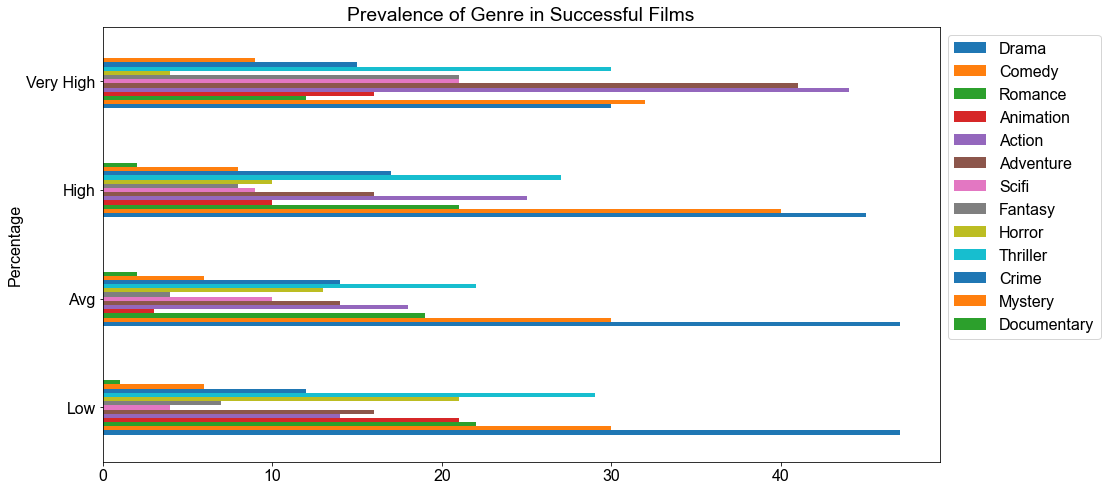

In [61]:
gc.plot.barh()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Percentage')
plt.style.use('seaborn-whitegrid')
plt.title('Prevalence of Genre in Successful Films')
plt.show()

In [85]:
bt = pd.DataFrame(budget_tier)
bt = bt.groupby('Budget Tier', as_index=True)
bt.head()

,Budget Tier,Budget(Millions),Average ROI,90th Quantile ROI,Max ROI
0,Low,$1.02 - 8,6.62%,7.78%,190.66%
1,Avg,$8.05 - 15,5.26%,8.34%,75.52%
2,High,$15.05 - 36,3.83%,6.19%,29.91%
3,Very High,$36.5 - 380,3.20%,5.20%,17.50%


#### Low Budget

In [63]:
# Cast 1
df[df.budget_range == 'low'].cast_actor_1.value_counts().head(10)

Clint Eastwood    19
John Wayne        16
Chuck Norris      14
Paul Newman       12
Ethan Hawke       12
Woody Allen       11
Gene Hackman      10
Sean Connery      10
Robert De Niro    10
Mel Gibson         9
Name: cast_actor_1, dtype: int64

In [64]:
# Cast 2
df[df.budget_range == 'low'].cast_actor_2.value_counts().head()

Susan Sarandon      8
Diane Keaton        8
Jamie Lee Curtis    7
Evan Rachel Wood    5
Juliette Binoche    5
Name: cast_actor_2, dtype: int64

In [ ]:
# Cast 3
df[df.budget_range == 'low'].cast_actor_3.value_counts().head()

In [ ]:
df[df.budget_range == 'low'].cast_actor_1.value_counts().tail(5)

In [ ]:
# Percent that we consider successful
df[df.budget_range == 'low'].success.value_counts(normalize=True)

In [ ]:
# Runtime
df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

In [ ]:
# Cast Size
df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

In [ ]:
# Genres
low_copy = df[(df.budget_range == 'low') & (df.success == 1) & (df.ROI > 10)]
low_copy.is_genre_drama.value_counts(normalize=True)

In [ ]:
low_copy.is_genre_crime.value_counts(normalize=True)

In [ ]:
low_copy.is_genre_horror.value_counts(normalize=True)

In [ ]:
low_copy.is_genre_thriller.value_counts(normalize=True)

In [ ]:
# 
low_copy.cast_actor_3.mode()

#### Avg Budget

In [ ]:
df[df.budget_range == 'avg'].cast_actor_1.value_counts().head()

In [ ]:
df[df.budget_range == 'avg'].cast_actor_2.value_counts().head()

In [ ]:
df[df.budget_range == 'avg'].cast_actor_3.value_counts().head()

In [ ]:
# Success Rate
df[df.budget_range == 'avg'].success.value_counts(normalize=True)

In [ ]:
# Runtime
df[(df.budget_range == 'avg') & (df.success == 1) & (df.ROI > 10)].runtime.mean()

In [ ]:
# Cast Size
df[(df.budget_range == 'avg') & (df.success == 1) & (df.ROI > 10)].total_n_cast.mean()

In [ ]:
avg_copy = df[(df.budget_range == 'avg') & (df.success == 1)]

In [ ]:
avg_copy.is_genre_drama.value_counts(normalize=True)

In [ ]:
avg_copy.is_genre_comedy.value_counts(normalize=True)

In [ ]:
avg_copy.is_genre_romance.value_counts(normalize=True)

In [ ]:
avg_copy.is_genre_scifi.value_counts(normalize=True)

In [ ]:
avg_copy.is_genre_action.value_counts(normalize=True)

In [ ]:
avg_copy.is_genre_adventure.value_counts(normalize=True)

#### High Budget

In [ ]:
df[df.budget_range == 'high'].cast_actor_1.value_counts().head()

In [ ]:
df[df.budget_range == 'high'].cast_actor_2.value_counts().head()

In [ ]:
df[df.budget_range == 'high'].cast_actor_3.value_counts().head()

In [ ]:
# Success Rate
df[df.budget_range == 'high'].success.value_counts(normalize=True)

In [ ]:
# Runtime
df[(df.budget_range == 'high') & (df.success == 1)].runtime.mean()

In [ ]:
# Cast Size
df[(df.budget_range == 'high') & (df.success == 1)].total_n_cast.mean()

In [ ]:
high_copy = df[(df.budget_range == 'high') & (df.success == 1)]

In [ ]:
high_copy.is_genre_action.value_counts(normalize=True)

In [ ]:
high_copy.is_genre_adventure.value_counts(normalize=True)

In [ ]:
high_copy.is_genre_drama.value_counts(normalize=True)

In [ ]:
high_copy.is_genre_comedy.value_counts(normalize=True)

In [ ]:
high_copy.is_genre_horror.value_counts(normalize=True)

In [ ]:
high_copy.is_genre_romance.value_counts(normalize=True)

In [ ]:
high_copy.is_genre_scifi.value_counts(normalize=True)

#### Very High Budget

In [ ]:
df[df.budget_range == 'very high'].cast_actor_1.value_counts().head()

In [ ]:
df[df.budget_range == 'very high'].cast_actor_2.value_counts().head()

In [ ]:
df[df.budget_range == 'very high'].cast_actor_3.value_counts().head()

In [ ]:
df[df.budget_range == 'very high'].success.value_counts(normalize=True)

In [ ]:
# Runtime
df[(df.budget_range == 'very high') & (df.success == 1) & (df.ROI > 3)].runtime.mean()


In [ ]:
# Cast Size
df[(df.budget_range == 'very high') & (df.success == 1) & (df.ROI > 3)].total_n_cast.mean()

In [ ]:
vh_copy = df[(df.budget_range == 'very high') & (df.success == 1)]

In [ ]:
vh_copy.is_genre_drama.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_comedy.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_romance.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_animation.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_horror.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_thriller.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_action.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_adventure.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_fantasy.value_counts(normalize=True)

In [ ]:
vh_copy.is_genre_scifi.value_counts(normalize=True)

In [ ]:
df[df.ROI == 4].total_n_cast.mean(

In [ ]:
df.head()